# Getting recommendations using Amazon Personalization and AWS Data Exchange

Recommended Time: 90 Min

## Prerequisites

To use this notebook you need to be suscribed to 

### Import Dependencies and Setup Boto3 Python Clients

Throughout this workshop we will need access to some common libraries and clients for connecting to AWS services. We also have to retrieve Uid from a SageMaker notebook instance tag.

In [1]:
# Import Dependencies

import boto3
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import csv
import sys
import botocore
import uuid

from datetime import datetime
from datetime import date
from packaging import version
from random import randint
from botocore.exceptions import ClientError


%matplotlib inline

# Setup Clients

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
personalize_events = boto3.client('personalize-events')
s3 = boto3.client('s3')

with open('/opt/ml/metadata/resource-metadata.json') as f:
  data = json.load(f)
sagemaker = boto3.client('sagemaker')
sagemakerResponce = sagemaker.list_tags(ResourceArn=data["ResourceArn"])
for tag in sagemakerResponce["Tags"]:
    if tag['Key'] == 'Uid':
        Uid = tag['Value']
        break

### Implement some visualization functions for displaying information of the products in a dataframe

Throughout this workshop we will need to search information of products several times, this function will help us to do it without repeating the same code.

In [2]:
def search_items_in_dataframe(item_list):
    df = pd.DataFrame() 
    for x in range(len(item_list)):
        temp = products_dataset_df.loc[products_dataset_df['ITEM_ID'] == int(item_list[x]['itemId'])]
        df = df.append(temp, ignore_index=True)
    pd.set_option('display.max_rows', 10)
    return df


### Configure Bucket and Data Output Location

We will be configuring some variables that will store the location of our source data. Substitute the name of the bucket we will create later with your own. 

In [3]:

bucket = ""     # Use your own bucket
items_filename = "items.csv"                # Do Not Change
users_filename = "users.csv"                # Do Not Change
interactions_filename = "interactions.csv"  # Do Not Change

## Get, Prepare, and Upload User, Product, and Interaction Data

First we need to create a bucket to store the datasets for Personalize to consume them. 

Download datasets.

Let's get started.

In [ ]:
# Substitute the '/dataset/object-key' by the key of the file copied by ADX containing the weather dataset

s3.download_file(bucket, '/dataset/object-key', 'weather_data.csv')

#### Download and Explore and clean the Weather Dataset

In [4]:
weather_df = pd.read_csv('weather_data.csv')
pd.set_option('display.max_rows', 5)
weather_df

,city,date,avgTemp,maxTemp,minTemp,prcp
0,Atlanta,20180101,23.5,29,18,0.00
1,Boston,20180101,6.5,13,0,0.00
...,...,...,...,...,...,...
6088,New York City,20201011,63.5,69,58,0.01
6089,Seattle,20201011,54.5,59,50,0.61


In [5]:
#Create a new DF with all the values related to Atlanta 
weather_df= weather_df[weather_df.city == 'Atlanta']
weather_df

,city,date,avgTemp,maxTemp,minTemp,prcp
0,Atlanta,20180101,23.5,29,18,0.00
2,Atlanta,20180102,24.5,36,13,0.00
...,...,...,...,...,...,...
2026,Atlanta,20201010,71.0,77,65,4.55
2028,Atlanta,20201011,72.5,75,70,0.05


In [6]:
#Helper function to find the temperature in weather dataset

def find_weather_data_by_timestamp(timestamp):
    date_ds = str(date.fromtimestamp(timestamp)).replace('-', '')
    data = weather_df.loc[weather_df['date'] == int(date_ds)]
    daily_temp = float (data['avgTemp'])
    daily_temp = int ((daily_temp - 32) * 5.0/9.0)
    
    if daily_temp < 5:
        return 'very cold'
    elif daily_temp >=5 and daily_temp < 10:
        return 'cold'
    elif daily_temp >=10 and daily_temp < 15:
        return 'slightly cold'
    elif daily_temp >= 15 and daily_temp < 21:
        return 'lukewarm'
    elif daily_temp >= 21 and daily_temp < 28:
        return 'hot'
    else:
        return 'very hot'
    return daily_temp


In [7]:
#test a sample timestamp
find_weather_data_by_timestamp(1587846700)

'lukewarm'

#### Download and Explore and clean the Products Dataset

In [8]:
products_df = pd.read_csv('./items-origin.csv')
pd.set_option('display.max_rows', 5)
products_df


,id,sk,name,category,type,size,price,featured,gender_affinity,sugar
0,1,NaN,Amber Lager,beers,beer,4x355,4.99,True,NaN,REGULAR
1,2,NaN,Cream Stout,beers,beer,4x330,3.99,True,F,REGULAR
...,...,...,...,...,...,...,...,...,...,...
54,55,NaN,Peach Nectar,juices,nectar,6x200,1.49,NaN,M,LOW
55,56,NaN,Coconut Water,other,coconut water,1x250,1.69,NaN,NaN,0%


### Clean the product dataset and drop columms we don't need.


#### Prepare products Data

When training models in Amazon Personalize, we can provide meta data about our items. For this workshop we will add each product's category and style to the item dataset. The product's unique identifier is required. Then we will rename the columns in our dataset to match our schema (defined later) and those expected by Personalize. Finally, we will save our dataset as a CSV and copy it to our S3 bucket.

In [9]:
products_dataset_df = products_df[['id','category','type', 'size']]


In [10]:
products_dataset_df['category'].unique()

array(['beers', 'sparkling', 'waters', 'juices', 'isotonic', 'other',
       'spirits', 'energy'], dtype=object)

In [11]:
products_dataset_df = products_dataset_df.rename(columns = {'id':'ITEM_ID','category':'CATEGORY','type':'TYPE', 'size':'SIZE'}) 


In [12]:
pd.set_option('display.max_rows', 5)
products_dataset_df

,ITEM_ID,CATEGORY,TYPE,SIZE
0,1,beers,beer,4x355
1,2,beers,beer,4x330
...,...,...,...,...
54,55,juices,nectar,6x200
55,56,other,coconut water,1x250


In [13]:
products_dataset_df.to_csv(items_filename, index=False)

#### Download and Explore the Users Dataset

In [14]:
users_df = pd.read_csv('./users-origin.csv')
pd.set_option('display.max_rows', 5)
users_df

,id,username,email,first_name,last_name,addresses,age,gender,persona
0,17,user17,annette.baker@example.com,Annette,Baker,"[{'first_name': 'Annette', 'last_name': 'Baker...",18,F,sparkling_waters_other
1,63,user63,cheryl.duncan@example.com,Cheryl,Duncan,"[{'first_name': 'Cheryl', 'last_name': 'Duncan...",18,F,waters_juices_other
...,...,...,...,...,...,...,...,...,...
5998,203,user203,ryan.barnes@example.com,Ryan,Barnes,"[{'first_name': 'Ryan', 'last_name': 'Barnes',...",81,M,waters_juices_other
5999,4521,user4521,paul.nelson@example.com,Paul,Nelson,"[{'first_name': 'Paul', 'last_name': 'Nelson',...",81,M,juices_waters_sparkling


#### Prepare products Data

Similar to the items dataset we created above, we can provide metadata on our users when training models in Amazon Personalize. For this workshop we will include each user's id and persona. As before, we will name the columns to match our schema, save the data as a CSV, and upload to our S3 bucket.

In [15]:
users_dataset_df = users_df[['id','persona']]
users_dataset_df = users_dataset_df.rename(columns = {'id':'USER_ID','persona':'PERSONA'}) 
users_dataset_df.head(5)

users_dataset_df.to_csv(users_filename, index=False)

In [16]:
users_dataset_df.head(5)

,USER_ID,PERSONA
0,17,sparkling_waters_other
1,63,waters_juices_other
2,74,isotonic_spirits_waters
3,88,spirits_beers_sparkling
4,144,waters_juices_other


In [ ]:
products_dataset_df.info()

### Create User-Items Interactions Dataset

To mimic user behavior, we will be generating a new dataset that represents user interactions with items. To make the interactions more realistic, we will use a predefined shopper persona for each user to generate event types for products matching that persona. This persona is composed by 3 categories, separated by the symbol "_". 
The upsampling process will create events for viewing products, add products to a cart, checking out, and completing orders.

In [17]:
%%time

# Minimum number of interactions to generate
min_interactions = 2000000

# Percentages of each event type to generate
product_added_percent = .08
cart_viewed_percent = .05
checkout_started_percent = .02
order_completed_percent = .01

# Count of interactions generated for each event type
product_viewed_count = 0
product_added_count = 0
cart_viewed_count = 0
checkout_started_count = 0
order_completed_count = 0

# How many days in the past (from initial date) to start generating interactions
days_back = 365

#selecting a start time between 2020/02/23 and 2020/10/22 to match the weather data from the sample
date_time_obj = datetime.strptime('2019-06-25 09:27:53', '%Y-%m-%d %H:%M:%S')
start_time = int(datetime.timestamp(date_time_obj))
#start_time = int(time.time())


next_timestamp = start_time - (days_back * 24 * 60 * 60)
seconds_increment = int((start_time - next_timestamp) / min_interactions)
next_update = start_time + 60

assert seconds_increment > 0, "Increase days_back or reduce min_interactions"

print('Minimum interactions to generate: {}'.format(min_interactions))
print('Days back: {}'.format(days_back))
print('Starting timestamp: {} ({})'.format(next_timestamp, time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(next_timestamp))))
print('Seconds increment: {}'.format(seconds_increment))

print("Generating interactions... (this may take a few minutes)")
interactions = 0

subsets_cache = {}

with open(interactions_filename, 'w') as outfile:
    f = csv.writer(outfile)
    f.writerow(["ITEM_ID", "USER_ID", "EVENT_TYPE", "TIMESTAMP", "DAILY_TEMPERATURE"])

    while interactions < min_interactions:
        #if (time.time() > next_update):
         #   rate = interactions / (time.time() - start_time)
          #  to_go = (min_interactions - interactions) / rate
           # print('Generated {} interactions so far ({:0.2f} seconds to go)'.format(interactions, to_go))
            #next_update += 60

        # Pick a random user
        user = users_df.sample().iloc[0]

        # Determine category affinity from user's persona
        persona = user['persona']
        preferred_categories = persona.split('_')       

        # Select category based on weighted preference of category order.
        category = np.random.choice(preferred_categories, 1, p=[0.6, 0.25, 0.15])[0]
        gender = user['gender']

        # Check if subset data frame is already cached for category & gender
        prods_subset_df = subsets_cache.get(category + gender)
                
        if prods_subset_df is None:
            # Select products from selected category without gender affinity or that match user's gender
            prods_subset_df = products_df.loc[(products_df['category'] == category)]
            # Update cache
            subsets_cache[category + gender] = prods_subset_df

        # Pick a random product from gender filtered subset
        product = prods_subset_df.sample().iloc[0]

        this_timestamp = next_timestamp + randint(0, seconds_increment)
        daily_temp = find_weather_data_by_timestamp(this_timestamp)
        f.writerow([product['id'],
                    user['id'], 
                    'ProductViewed',
                    this_timestamp,
                    daily_temp])

        next_timestamp += seconds_increment
        product_viewed_count += 1
        interactions += 1

        if product_added_count < int(product_viewed_count * product_added_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            daily_temp = find_weather_data_by_timestamp(this_timestamp)
            f.writerow([product['id'],
                        user['id'], 
                        'ProductAdded',
                        this_timestamp,
                        daily_temp])
            interactions += 1
            product_added_count += 1

        if cart_viewed_count < int(product_viewed_count * cart_viewed_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            daily_temp = find_weather_data_by_timestamp(this_timestamp)
            f.writerow([product['id'],
                        user['id'], 
                        'CartViewed',
                        this_timestamp,
                        daily_temp])
            interactions += 1
            cart_viewed_count += 1

        if checkout_started_count < int(product_viewed_count * checkout_started_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            daily_temp = find_weather_data_by_timestamp(this_timestamp)
            f.writerow([product['id'],
                        user['id'], 
                        'CheckoutStarted',
                        this_timestamp,
                        daily_temp])
            interactions += 1
            checkout_started_count += 1

        if order_completed_count < int(product_viewed_count * order_completed_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            daily_temp = find_weather_data_by_timestamp(this_timestamp)
            f.writerow([product['id'],
                        user['id'], 
                        'OrderCompleted',
                        this_timestamp,
                        daily_temp])
            interactions += 1
            order_completed_count += 1
    
print("Done")
print("Total interactions: " + str(interactions))
print("Total product viewed: " + str(product_viewed_count))
print("Total product added: " + str(product_added_count))
print("Total cart viewed: " + str(cart_viewed_count))
print("Total checkout started: " + str(checkout_started_count))
print("Total order completed: " + str(order_completed_count))

Minimum interactions to generate: 2000000
Days back: 365
Starting timestamp: 1529918873 (2018-06-25 09:27:53)
Seconds increment: 15
Generating interactions... (this may take a few minutes)
Done
Total interactions: 2000001
Total product viewed: 1724140
Total product added: 137931
Total cart viewed: 86207
Total checkout started: 34482
Total order completed: 17241
CPU times: user 45min 23s, sys: 1.44 s, total: 45min 24s
Wall time: 45min 26s


#### Open and Explore the Interactions Dataset

In [18]:
interactions_df = pd.read_csv(interactions_filename)
interactions_df

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP,DAILY_TEMPERATURE
0,50,3271,ProductViewed,1529918883,hot
1,32,2228,ProductViewed,1529918900,hot
...,...,...,...,...,...
1999999,1,3739,ProductViewed,1555780961,cold
2000000,1,3739,CartViewed,1555780962,cold


Chart the counts of each `EVENT_TYPE` generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

<AxesSubplot:xlabel='EVENT_TYPE', ylabel='count'>

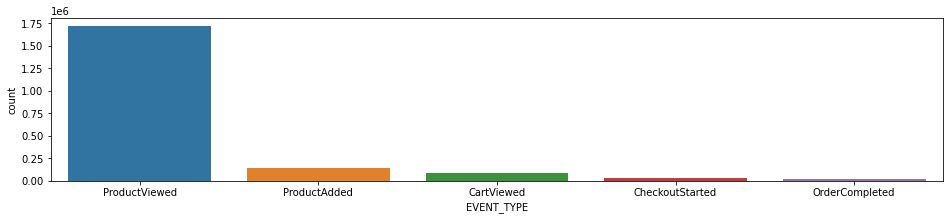

In [19]:
categorical_attributes = interactions_df.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
sns.countplot(data = categorical_attributes, x = 'EVENT_TYPE')

Take note of the DAILY_TEMPERATURE values included in our interaction dataset, you will be using them for getting recomendations. 

In [20]:
interactions_df['DAILY_TEMPERATURE'].unique()

array(['hot', 'very hot', 'lukewarm', 'slightly cold', 'cold',
       'very cold'], dtype=object)

Chart the counts of each DAILY_TEMPERATURE generated for the interactions dataset. Check how the temperature is changing during the seasonality of the sample interactions.

<AxesSubplot:xlabel='DAILY_TEMPERATURE', ylabel='count'>

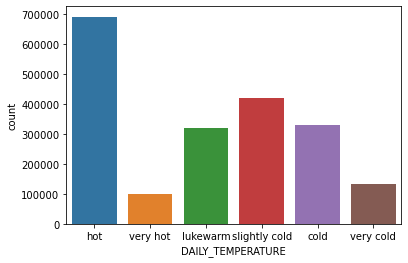

In [21]:
sns.countplot(data = categorical_attributes, x = 'DAILY_TEMPERATURE')

#### Upload Data
Now we will upload the data we prepared to S3.

In [22]:
boto3.Session().resource('s3').Bucket(bucket).Object(interactions_filename).upload_file(interactions_filename)

In [23]:
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

In [24]:
boto3.Session().resource('s3').Bucket(bucket).Object(users_filename).upload_file(users_filename)

## Configure Amazon Personalize

Now that we've prepared our three datasets and uploaded them to S3 we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations.

### Create Schemas for Datasets

Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format.

Let's define and create schemas in Personalize for our datasets.

#### Items Dataset Schema

In [25]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CATEGORY",
            "type": "string",
            "categorical": True,
        },
        {
            "name": "TYPE",
            "type": "string",
            "categorical": True,
        },
        {
            "name": "SIZE",
            "type": "string",
            "categorical": True,
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "adx-weather-schema-items",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:903376376581:schema/adx-weather-schema-items",
  "ResponseMetadata": {
    "RequestId": "68bed50f-deca-4b3d-aaeb-4bc2f49dabea",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:40:13 GMT",
      "x-amzn-requestid": "68bed50f-deca-4b3d-aaeb-4bc2f49dabea",
      "content-length": "90",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Users Dataset Schema

In [26]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "PERSONA",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "adx-weather-users",
    schema = json.dumps(users_schema)
)

users_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:903376376581:schema/adx-weather-users",
  "ResponseMetadata": {
    "RequestId": "796aa762-8976-4922-a0a3-9720b34d551a",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:40:16 GMT",
      "x-amzn-requestid": "796aa762-8976-4922-a0a3-9720b34d551a",
      "content-length": "83",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Interactions Dataset Schema

In [27]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "DAILY_TEMPERATURE",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "adx-weather-interactions",
    schema = json.dumps(interactions_schema)
)

interactions_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:903376376581:schema/adx-weather-interactions",
  "ResponseMetadata": {
    "RequestId": "8aaff0a1-1396-4c6f-a91b-af0a89d93dc1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:40:18 GMT",
      "x-amzn-requestid": "8aaff0a1-1396-4c6f-a91b-af0a89d93dc1",
      "content-length": "90",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create and Wait for Dataset Group

Next we need to create the dataset group that will contain our three datasets.

#### Create Dataset Group

In [28]:
create_dataset_group_response = personalize.create_dataset_group(
    name = 'adx-weather-dataset'
)
dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

print(f'DatasetGroupArn = {dataset_group_arn}')

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:903376376581:dataset-group/adx-weather-dataset",
  "ResponseMetadata": {
    "RequestId": "9c80dbde-ff24-4700-9f9b-89bec1e04012",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:40:22 GMT",
      "x-amzn-requestid": "9c80dbde-ff24-4700-9f9b-89bec1e04012",
      "content-length": "98",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:us-east-1:903376376581:dataset-group/adx-weather-dataset


#### Wait for Dataset Group to Have ACTIVE Status

In [29]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### Create Items Dataset

Next we will create the datasets in Personalize for our three dataset types. Let's start with the items dataset.

In [30]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "adx-weather-dataset-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:903376376581:dataset/adx-weather-dataset/ITEMS",
  "ResponseMetadata": {
    "RequestId": "b3a09e69-3e06-4375-bdf7-13c99f796e8f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:43:04 GMT",
      "x-amzn-requestid": "b3a09e69-3e06-4375-bdf7-13c99f796e8f",
      "content-length": "93",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Users Dataset

In [31]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name = "adx-weather-dataset-users",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = users_schema_arn
)

users_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:903376376581:dataset/adx-weather-dataset/USERS",
  "ResponseMetadata": {
    "RequestId": "1e461e3d-c895-48a2-8bb0-26952cd9e9ee",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:43:07 GMT",
      "x-amzn-requestid": "1e461e3d-c895-48a2-8bb0-26952cd9e9ee",
      "content-length": "93",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Interactions Dataset

In [32]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "adx-weather-dataset-interactions",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:903376376581:dataset/adx-weather-dataset/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "971d923f-9d16-409a-b30e-82b891264353",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:43:10 GMT",
      "x-amzn-requestid": "971d923f-9d16-409a-b30e-82b891264353",
      "content-length": "100",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Import Datasets to Personalize

Up to this point we have generated CSVs containing data for our users, items, and interactions and staged them in an S3 bucket. We also created schemas in Personalize that define the columns in our CSVs. Then we created a datset group and three datasets in Personalize that will receive our data. In the following steps we will create import jobs with Personalize that will import the datasets from our S3 bucket into the service.

### Setup Permissions

By default, the Personalize service does not have permission to acccess the data we uploaded into the S3 bucket in our account. In order to grant access to the  Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume.

#### Attach policy to S3 bucket

In [33]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy));

#### Create S3 Read Only Access Role

In [ ]:
iam = boto3.client("iam")

role_name = 'CPG'+"-PersonalizeS3"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
);

iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
);

role_arn = create_role_response["Role"]["Arn"]
print('IAM Role: {}'.format(role_arn))
# Pause to allow role to fully persist
time.sleep(10)

### Create Import Jobs

With the permissions in place to allow Personalize to access our CSV files, let's create three import jobs to import each file into its respective dataset. Each import job can take several minutes to complete so we'll create all three and then wait for them all to complete.

#### Create Items Dataset Import Job

In [34]:
items_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "adx-weather-dataset-items-import-job",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, items_filename)
    },
    roleArn = role_arn
)

items_dataset_import_job_arn = items_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(items_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:903376376581:dataset-import-job/adx-weather-dataset-items-import-job",
  "ResponseMetadata": {
    "RequestId": "746d4668-8335-49a2-abed-b6238d55387f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:43:48 GMT",
      "x-amzn-requestid": "746d4668-8335-49a2-abed-b6238d55387f",
      "content-length": "124",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Users Dataset Import Job

In [35]:
users_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "adx-weather-dataset-users-import-job",
    datasetArn = users_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, users_filename)
    },
    roleArn = role_arn
)

users_dataset_import_job_arn = users_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(users_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:903376376581:dataset-import-job/adx-weather-dataset-users-import-job",
  "ResponseMetadata": {
    "RequestId": "ba13338e-e073-4cc2-b859-8abe1ce2cd8f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:43:51 GMT",
      "x-amzn-requestid": "ba13338e-e073-4cc2-b859-8abe1ce2cd8f",
      "content-length": "124",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Interactions Dataset Import Job

In [36]:
interactions_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "adx-weather-dataset-interactions-import-job",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, interactions_filename)
    },
    roleArn = role_arn
)

interactions_dataset_import_job_arn = interactions_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(interactions_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:903376376581:dataset-import-job/adx-weather-dataset-interactions-import-job",
  "ResponseMetadata": {
    "RequestId": "37c3fbeb-06c7-4a95-891b-e6a9d555597e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:43:54 GMT",
      "x-amzn-requestid": "37c3fbeb-06c7-4a95-891b-e6a9d555597e",
      "content-length": "131",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Import Jobs to Complete

It will take 10-15 minutes for the import jobs to complete, while you're waiting you can learn more about Datasets and Schemas here: https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html

We will wait for all three jobs to finish.

#### Wait for Items Import Job to Complete

In [37]:
%%time

import_job_arns = [ items_dataset_import_job_arn, users_dataset_import_job_arn, interactions_dataset_import_job_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for job_arn in reversed(import_job_arns):
        import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = job_arn
        )
        status = import_job_response["datasetImportJob"]['status']

        if status == "ACTIVE":
            print(f'Import job {job_arn} successfully completed')
            import_job_arns.remove(job_arn)
        elif status == "CREATE FAILED":
            print(f'Import job {job_arn} failed')
            if import_job_response.get('failureReason'):
                print('   Reason: ' + import_job_response['failureReason'])
            import_job_arns.remove(job_arn)

    if len(import_job_arns) > 0:
        print('At least one dataset import job still in progress')
        time.sleep(60)
    else:
        print("All import jobs have ended")
        break

At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
Import job arn:aws:personalize:us-east-1:903376376581:dataset-import-job/adx-weather-dataset-interactions-import-job successfully completed
At least one dataset import job still in progress
At least one dataset import job still in progress
Import job arn:aws:personalize:us-east-1:903376376581:dataset-import-job/adx-weather-dataset-users-import-job successfully completed
Import job arn:aws:personalize:us-east-1:903376376581:dataset-import-job/adx-weather-dataset-items-import-job successfully completed
All import jobs have ended
CPU times: user 55.3 ms, sys: 12 ms, total: 67.3 ms
Wall time: 6min


## Create Solutions

With our three datasets imported into our dataset group, we can now turn to training models. 
When creating a solution, you provide your dataset group and the recipe for training. Let's declare the recipes that we will need for our solutions.

### List Recipes

First, let's list all available recipes.

In [ ]:
list_recipes_response = personalize.list_recipes()
list_recipes_response

As you can see above, there are several recipes to choose from. Let's use only the Product Recommendations

#### Declare Personalize Recipe for Product Recommendations


In [38]:
recommend_recipe_arn = "arn:aws:personalize:::recipe/aws-user-personalization"

### Create Solutions and Solution Versions

With our recipes defined, we can now create our solutions and solution versions.

#### Create Product Recommendation Solution

In [39]:
create_solution_response = personalize.create_solution(
    name = "adx-weather-product-personalization",
    datasetGroupArn = dataset_group_arn,
    recipeArn = recommend_recipe_arn
)

recommend_solution_arn = create_solution_response['solutionArn']
print(json.dumps(create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-east-1:903376376581:solution/adx-weather-product-personalization",
  "ResponseMetadata": {
    "RequestId": "aa23e3be-2e62-492c-8436-752e3f359326",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:51:07 GMT",
      "x-amzn-requestid": "aa23e3be-2e62-492c-8436-752e3f359326",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Product Recommendation Solution Version

In [40]:
create_solution_version_response = personalize.create_solution_version(
    solutionArn = recommend_solution_arn
)

recommend_solution_version_arn = create_solution_version_response['solutionVersionArn']
print(json.dumps(create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:903376376581:solution/adx-weather-product-personalization/f7a06b4f",
  "ResponseMetadata": {
    "RequestId": "bd10d702-0b42-4bbf-ac27-673e778476de",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 19:51:11 GMT",
      "x-amzn-requestid": "bd10d702-0b42-4bbf-ac27-673e778476de",
      "content-length": "121",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Solution Versions to Complete

It can take 40-60 minutes for all solution versions to be created. During this process a model is being trained and tested with the data contained within your datasets. The duration of training jobs can increase based on the size of the dataset, training parameters and using AutoML vs. manually selecting a recipe. We submitted requests for all three solutions and versions at once so they are trained in parallel and then below we will wait for all three to finish.

While you are waiting for this process to complete you can learn more about solutions here: https://docs.aws.amazon.com/personalize/latest/dg/training-deploying-solutions.html

#### Wait for Related Products Solution Version to Have ACTIVE Status

In [41]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    soln_ver_response = personalize.describe_solution_version(
        solutionVersionArn = recommend_solution_version_arn
    )
    status = soln_ver_response["solutionVersion"]["status"]
    time.sleep(10)
    print(status)
    if status == "ACTIVE":
        print(f'Solution version {recommend_solution_version_arn} successfully completed')
        break
    elif status == "CREATE FAILED":
        print(f'Solution version {soln_ver_arn} failed')
        if soln_ver_response.get('failureReason'):
            print('   Reason: ' + soln_ver_response['failureReason'])


CREATE PENDING
CREATE PENDING
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
C

### Evaluate Offline Metrics for Solution Versions

Amazon Personalize provides [offline metrics](https://docs.aws.amazon.com/personalize/latest/dg/working-with-training-metrics.html#working-with-training-metrics-metrics) that allow you to evaluate the performance of the solution version before you deploy the model in your application. Metrics can also be used to view the effects of modifying a Solution's hyperparameters or to compare the metrics between solutions that use the same training data but created with different recipes.

Let's retrieve the metrics for the solution versions we just created.

#### Product Recommendations Metrics

In [42]:
get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = recommend_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:903376376581:solution/adx-weather-product-personalization/f7a06b4f",
  "metrics": {
    "coverage": 0.9825,
    "mean_reciprocal_rank_at_25": 0.8703,
    "normalized_discounted_cumulative_gain_at_10": 0.7174,
    "normalized_discounted_cumulative_gain_at_25": 0.8607,
    "normalized_discounted_cumulative_gain_at_5": 0.7432,
    "precision_at_10": 0.652,
    "precision_at_25": 0.4159,
    "precision_at_5": 0.7331
  },
  "ResponseMetadata": {
    "RequestId": "97c3c90b-e0af-48cf-89c1-d7170fd803e8",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 20:32:41 GMT",
      "x-amzn-requestid": "97c3c90b-e0af-48cf-89c1-d7170fd803e8",
      "content-length": "418",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Create Campaigns

Once we're satisfied with our solution versions, we need to create Campaigns for each solution version. When creating a campaign you specify the minimum transactions per second (`minProvisionedTPS`) that you expect to make against the service for this campaign. Personalize will automatically scale the inference endpoint up and down for the campaign to match demand but will never scale below `minProvisionedTPS`.

Let's create campaigns for our three solution versions with each set at `minProvisionedTPS` of 1.

#### Create Product Recommendation Campaign

In [43]:
create_campaign_response = personalize.create_campaign(
    name = "adx-weather-product-personalization",
    solutionVersionArn = recommend_solution_version_arn,
    minProvisionedTPS = 1
)

recommend_campaign_arn = create_campaign_response['campaignArn']
print(json.dumps(create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:us-east-1:903376376581:campaign/adx-weather-product-personalization",
  "ResponseMetadata": {
    "RequestId": "f68d6550-2019-4b7e-a592-340a9ec8f9b4",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Mon, 20 Sep 2021 20:32:53 GMT",
      "x-amzn-requestid": "f68d6550-2019-4b7e-a592-340a9ec8f9b4",
      "content-length": "105",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Wait for Related Products Campaign to Have ACTIVE Status

It can take 20-30 minutes for the campaigns to be fully created. 

While you are waiting for this to complete you can learn more about campaigns here: https://docs.aws.amazon.com/personalize/latest/dg/campaigns.html

In [44]:
%%time
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    campaign_response = personalize.describe_campaign(
        campaignArn = recommend_campaign_arn
    )
    status = campaign_response["campaign"]["status"]
    time.sleep(10)
    print(status)

    if status == "ACTIVE":
        print(f'Campaign {recommend_campaign_arn} successfully completed')
        break
    elif status == "CREATE FAILED":
        print(f'Campaign {campaign_arn} failed')
        if campaign_response.get('failureReason'):
            print('   Reason: ' + campaign_response['failureReason'])

CREATE PENDING
CREATE PENDING
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
CREATE IN_PROGRESS
C

## Test Campaigns

Now that our campaigns have been fully created, let's test each campaign and evaluate the results.

### Test Product Recommendations Campaign

Let's test the recommendations made by the product recommendations campaign by selecting a user from the users dataset and requesting item recommendations for that user.

#### Select a User

We'll just pick a random user for simplicity. Feel free to change the `user_id` below and execute the following cells with a different user to get a sense for how the recommendations change.

In [45]:
# User with interactions 170
# Cold start user 7000
user_id = 170
users_df.loc[users_df['id'] == user_id]

,id,username,email,first_name,last_name,addresses,age,gender,persona
1995,170,user170,clifford.mueller@example.com,Clifford,Mueller,"[{'first_name': 'Clifford', 'last_name': 'Muel...",30,M,other_waters_sparkling


**Take note of the `persona` value for the user above. We should see recommendations for products consistent with this persona since we generated historical interactions for products in the categories represented in the persona.**

#### Get Product Recommendations for User

Now let's call Amazon Personalize to get recommendations for our user from the product recommendations campaign.

In [52]:
get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = recommend_campaign_arn,
    userId = str(user_id),
    numResults = 5)

item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=4))
search_items_in_dataframe(item_list)

[
    {
        "itemId": "4",
        "score": 0.0610027
    },
    {
        "itemId": "12",
        "score": 0.0608411
    },
    {
        "itemId": "54",
        "score": 0.0558495
    },
    {
        "itemId": "40",
        "score": 0.0487231
    },
    {
        "itemId": "28",
        "score": 0.0450286
    }
]


,ITEM_ID,CATEGORY,TYPE,SIZE
0,4,waters,sparkling,6x1500
1,12,waters,normal,6x1500
2,54,waters,flavored,4x500
3,40,waters,normal,6x1600
4,28,waters,sparkling,6x1600


Are the recommended products consistent with the persona? Note that this is a rather contrived example using a limited amount of generated interaction data without model parameter tuning. The purpose is to give you hands on experience building models and retrieving inferences from Amazon Personalize. 

## Contextual recomendations

Now lets explore the possibility of passing contextual information to the recomendation call. Context can be any attribute included in the Interactions dataset used to train the solution. in our case we included the average temperature of each day in Atlanta extracted from WeatherTrends360 dataset:https://aws.amazon.com/marketplace/pp/prodview-wbuuretid73x4?sr=0-3&ref_=beagle&applicationId=AWSMPContessa#offers.

If you want to try your own solutions feel free to explore other dataset on the AWS Marketplace.  

Other useful contextual informacion can be the device or trade channel used to interact and other similar metadata alike. More information: https://aws.amazon.com/blogs/machine-learning/increasing-the-relevance-of-your-amazon-personalize-recommendations-by-leveraging-contextual-information/

Lets select a user and test the recomendations for the included temperature ranges.


In [51]:
user_id = 10000
users_dataset_df.loc[users_dataset_df['USER_ID'] == user_id]


,USER_ID,PERSONA


In [61]:
# DAILY TEMPERATURE = ['hot', 'very hot', 'lukewarm', 'slightly cold', 'cold', 'very cold']

get_recommendations_response = personalize_runtime.get_recommendations(
    campaignArn = recommend_campaign_arn,
    userId = str(user_id),
    numResults = 5,
    context = {
      'DAILY_TEMPERATURE': 'slightly cold'
    })

item_list = get_recommendations_response['itemList']
print(json.dumps(item_list, indent=4))
search_items_in_dataframe(item_list)

[
    {
        "itemId": "4",
        "score": 0.0749273
    },
    {
        "itemId": "54",
        "score": 0.0683786
    },
    {
        "itemId": "12",
        "score": 0.0577067
    },
    {
        "itemId": "28",
        "score": 0.0558818
    },
    {
        "itemId": "20",
        "score": 0.0487305
    }
]


,ITEM_ID,CATEGORY,TYPE,SIZE
0,4,waters,sparkling,6x1500
1,54,waters,flavored,4x500
2,12,waters,normal,6x1500
3,28,waters,sparkling,6x1600
4,20,waters,flavored,6x1500


The items recommended are different from the previous calls? Try different users, values and amount of items recommended to get a grasp of the behavior. 

## Workshop Complete

Congratulations! You have completed the contextual Weather Personalization Workshop.

### Cleanup

You MUST run the cleanup notebook or manually clean up these resources. If using the notebook, save the names of the elements to be cleaned:

In [ ]:
%store dataset_group_arn
%store items_dataset_arn
%store users_dataset_arn
%store interactions_dataset_arn
%store role_arn
%store users_dataset_import_job_arn
%store interactions_dataset_import_job_arn
%store items_dataset_import_job_arn
%store recommend_campaign_arn